In [3]:
import language_tool_python

tool = language_tool_python.LanguageTool('pl')

In [ ]:
import language_tool_python

tool = language_tool_python.LanguageTool('pl')

def correct_polish_text(text):
    max_iterations = 3  # To prevent potential infinite loops
    for _ in range(max_iterations):
        matches = tool.check(text)
        if not matches:
            break
        corrected_parts = []
        last_pos = 0
        for match in matches:
            start = match.offset
            end = start + match.errorLength
            corrected_parts.append(text[last_pos:start])
            if match.replacements:
                corrected_parts.append(match.replacements[0])
            else:
                corrected_parts.append(text[start:end])
            last_pos = end
        corrected_parts.append(text[last_pos:])
        text = ''.join(corrected_parts)
    return text

# Example usage:
text = "Cześć, jestem Marcni— co tam u czbiy sychać!"
corrected_text = correct_polish_text(text)
print(corrected_text)

Cześć, jestem Marcin — co tam u czbiy słychać!


Transcribing Samples: 100%|██████████| 10/10 [00:05<00:00,  1.68sample/s]


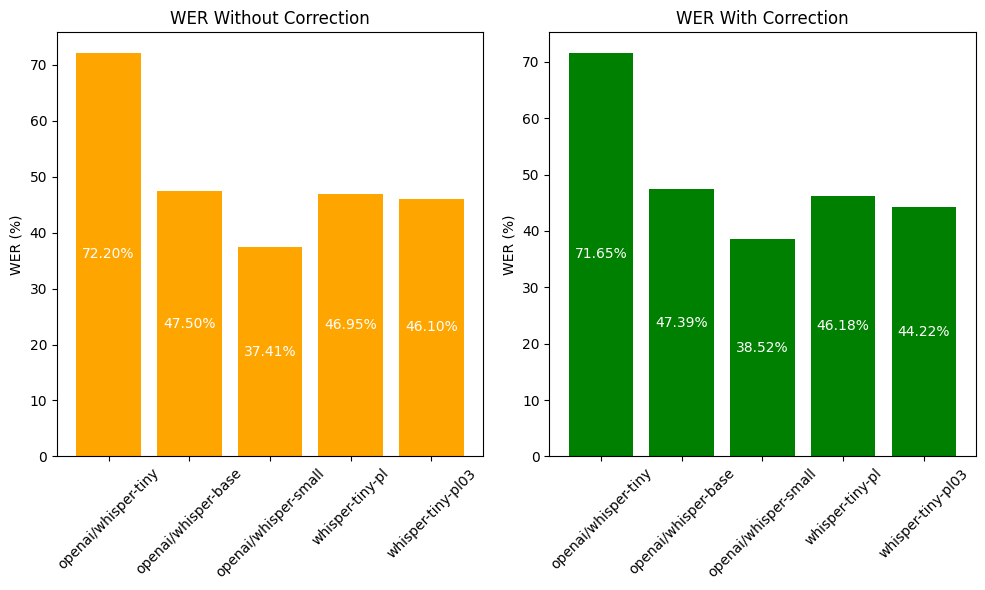

C:\Users\kogut\AppData\Local\Temp\ipykernel_8684\2038212459.py:140: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes_times[0].boxplot(all_times_without, labels=model_names, patch_artist=True, boxprops=dict(facecolor="skyblue"))
C:\Users\kogut\AppData\Local\Temp\ipykernel_8684\2038212459.py:146: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes_times[1].boxplot(all_times_with, labels=model_names, patch_artist=True, boxprops=dict(facecolor="lightcoral"))


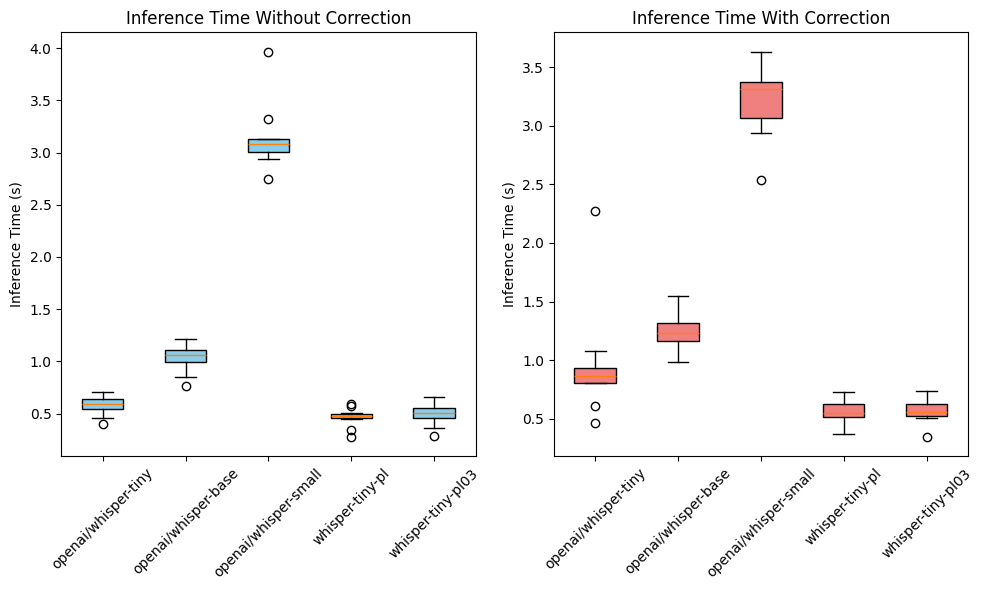

In [5]:
import os
import time
import torchaudio
import pandas as pd
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from tqdm import tqdm
import matplotlib.pyplot as plt
import evaluate
import language_tool_python

tool = language_tool_python.LanguageTool('pl')

def correct_polish_text(text):
    max_iterations = 3 
    for _ in range(max_iterations):
        matches = tool.check(text)
        if not matches:
            break
        corrected_parts = []
        last_pos = 0
        for match in matches:
            start = match.offset
            end = start + match.errorLength
            corrected_parts.append(text[last_pos:start])
            if match.replacements:
                corrected_parts.append(match.replacements[0])
            else:
                corrected_parts.append(text[start:end])
            last_pos = end
        corrected_parts.append(text[last_pos:])
        text = ''.join(corrected_parts)
    return text

metric = evaluate.load("wer")

def compute_metrics(pred, processor):
    pred_ids = pred["predictions"]
    label_ids = pred["label_ids"]
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    pred_str = [p.lower() for p in pred_str]
    label_str = [l.lower() for l in label_str]
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"eval_wer": wer}

def transcribe_samples(model, processor, samples, correct_text=False):
    results = []
    times = []
    predictions = []
    references = []
    wer_list = []

    for sample in tqdm(samples, desc=f"Transcribing Samples", unit="sample"):
        waveform, sample_rate = torchaudio.load(sample["file_path"])
        if sample_rate != processor.feature_extractor.sampling_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, processor.feature_extractor.sampling_rate)
            waveform = resampler(waveform)
        input_features = processor(waveform.squeeze(0), sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt").input_features

        reference_str = sample["reference"]

        start_time = time.time()
        pred_ids = model.generate(input_features)
        pred_str = processor.decode(pred_ids[0], skip_special_tokens=True)
        if correct_text:
            pred_str = correct_polish_text(pred_str)
        end_time = time.time()

        predictions.append(pred_str)
        references.append(reference_str)
        times.append(end_time - start_time)

        pred = {
            "predictions": processor.tokenizer(pred_str, return_tensors="pt", padding=True, truncation=True).input_ids,
            "label_ids": processor.tokenizer(reference_str, return_tensors="pt", padding=True, truncation=True).input_ids,
        }
        metrics = compute_metrics(pred, processor)
        wer_list.append(metrics["eval_wer"])

        results.append({"reference": reference_str, "transcription": pred_str})

    return results, times, wer_list, predictions, references

def evaluate_models(model_paths, samples, correct_text=False):
    results = {}
    times_all = {}
    wer_all = {}

    for model_path in model_paths:
        processor = WhisperProcessor.from_pretrained(model_path, language="pl", task="transcribe")
        model = WhisperForConditionalGeneration.from_pretrained(model_path)
        model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="pl", task="transcribe")

        transcriptions, times, wer_list, predictions, references = transcribe_samples(model, processor, samples, correct_text)

        overall_pred = {
            "predictions": processor.tokenizer(predictions, padding=True, truncation=True, return_tensors="pt").input_ids,
            "label_ids": processor.tokenizer(references, padding=True, truncation=True, return_tensors="pt").input_ids,
        }
        overall_metrics = compute_metrics(overall_pred, processor)

        results[model_path] = overall_metrics["eval_wer"]
        times_all[model_path] = times
        wer_all[model_path] = wer_list

    return results, times_all, wer_all

def plot_wer_and_times(times_all_without, wer_all_without, times_all_with, wer_all_with):
    model_names = list(times_all_without.keys())
    
    fig_wer, axes_wer = plt.subplots(1, 2, figsize=(10, 6))
    
    wer_values_without = [wer_all_without[model_path] for model_path in model_names]
    avg_wer_without = [sum(wer) / len(wer) for wer in wer_values_without]
    bars_without = axes_wer[0].bar(model_names, avg_wer_without, color='orange')
    axes_wer[0].set_title("WER Without Correction")
    axes_wer[0].set_ylabel("WER (%)")
    axes_wer[0].tick_params(axis='x', rotation=45)
    for bar, wer in zip(bars_without, avg_wer_without):
        axes_wer[0].text(bar.get_x() + bar.get_width() / 2, wer / 2, f'{wer:.2f}%', 
                         ha='center', va='center', fontsize=10, color='white')
    
    wer_values_with = [wer_all_with[model_path] for model_path in model_names]
    avg_wer_with = [sum(wer) / len(wer) for wer in wer_values_with]
    bars_with = axes_wer[1].bar(model_names, avg_wer_with, color='green')
    axes_wer[1].set_title("WER With Correction")
    axes_wer[1].set_ylabel("WER (%)")
    axes_wer[1].tick_params(axis='x', rotation=45)
    for bar, wer in zip(bars_with, avg_wer_with):
        axes_wer[1].text(bar.get_x() + bar.get_width() / 2, wer / 2, f'{wer:.2f}%', 
                         ha='center', va='center', fontsize=10, color='white')
    
    plt.tight_layout()
    plt.show()
    
    fig_times, axes_times = plt.subplots(1, 2, figsize=(10, 6))
    
    all_times_without = [times_all_without[model_path] for model_path in model_names]
    axes_times[0].boxplot(all_times_without, labels=model_names, patch_artist=True, boxprops=dict(facecolor="skyblue"))
    axes_times[0].set_title("Inference Time Without Correction")
    axes_times[0].set_ylabel("Inference Time (s)")
    axes_times[0].tick_params(axis='x', rotation=45)
    
    all_times_with = [times_all_with[model_path] for model_path in model_names]
    axes_times[1].boxplot(all_times_with, labels=model_names, patch_artist=True, boxprops=dict(facecolor="lightcoral"))
    axes_times[1].set_title("Inference Time With Correction")
    axes_times[1].set_ylabel("Inference Time (s)")
    axes_times[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

audio_folder = "clips"
data = pd.read_csv("validated.tsv", sep="\t")
samples = []
for index, row in data.iterrows():
    file_path = os.path.join(audio_folder, row["path"])
    if os.path.exists(file_path):
        samples.append({"file_path": file_path, "reference": row["sentence"]})
        
model_folders = ["openai/whisper-tiny", "openai/whisper-base", "openai/whisper-small"]
model_folders.extend([folder_name for folder_name in os.listdir() if folder_name.startswith("whisper")])

results_without_correction, times_all_without_correction, wer_all_without_correction = evaluate_models(model_folders, samples[:10], correct_text=False)

results_with_correction, times_all_with_correction, wer_all_with_correction = evaluate_models(model_folders, samples[:10], correct_text=True)

plot_wer_and_times(times_all_without_correction, wer_all_without_correction, 
                   times_all_with_correction, wer_all_with_correction)

In [ ]:
import os
import time
import torchaudio
import torch
import pandas as pd
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from tqdm import tqdm
import matplotlib.pyplot as plt
import evaluate
import language_tool_python

tool = language_tool_python.LanguageTool('pl')

def correct_polish_text(text):
    max_iterations = 3 
    for _ in range(max_iterations):
        matches = tool.check(text)
        if not matches:
            break
        corrected_parts = []
        last_pos = 0
        for match in matches:
            start = match.offset
            end = start + match.errorLength
            corrected_parts.append(text[last_pos:start])
            if match.replacements:
                corrected_parts.append(match.replacements[0])
            else:
                corrected_parts.append(text[start:end])
            last_pos = end
        corrected_parts.append(text[last_pos:])
        text = ''.join(corrected_parts)
    return text

metric = evaluate.load("wer")

def compute_metrics(pred, processor):
    pred_ids = pred["predictions"]
    label_ids = pred["label_ids"]
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    pred_str = [p.lower() for p in pred_str]
    label_str = [l.lower() for l in label_str]
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"eval_wer": wer}

def transcribe_samples(model, processor, samples, correct_text=False):
    results = []
    times = []
    predictions = []
    references = []
    wer_list = []

    for sample in tqdm(samples, desc=f"Transcribing Samples", unit="sample"):
        waveform, sample_rate = torchaudio.load(sample["file_path"])
        if sample_rate != processor.feature_extractor.sampling_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, processor.feature_extractor.sampling_rate)
            waveform = resampler(waveform)
        input_features = processor(waveform.squeeze(0), sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt").input_features

        reference_str = sample["reference"]

        start_time = time.time()
        pred_ids = model.generate(input_features)
        pred_str = processor.decode(pred_ids[0], skip_special_tokens=True)
        if correct_text:
            pred_str = correct_polish_text(pred_str)
        end_time = time.time()

        predictions.append(pred_str)
        references.append(reference_str)
        times.append(end_time - start_time)

        pred = {
            "predictions": processor.tokenizer(pred_str, return_tensors="pt", padding=True, truncation=True).input_ids,
            "label_ids": processor.tokenizer(reference_str, return_tensors="pt", padding=True, truncation=True).input_ids,
        }
        metrics = compute_metrics(pred, processor)
        wer_list.append(metrics["eval_wer"])

        results.append({"reference": reference_str, "transcription": pred_str})

    return results, times, wer_list, predictions, references

def evaluate_models(model_paths, samples, correct_text=False):
    results = {}
    times_all = {}
    wer_all = {}

    for model_path in model_paths:
        processor = WhisperProcessor.from_pretrained(model_path, language="pl", task="transcribe")
        model = WhisperForConditionalGeneration.from_pretrained(model_path)
        model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="pl", task="transcribe")

        transcriptions, times, wer_list, predictions, references = transcribe_samples(model, processor, samples, correct_text)

        overall_pred = {
            "predictions": processor.tokenizer(predictions, padding=True, truncation=True, return_tensors="pt").input_ids,
            "label_ids": processor.tokenizer(references, padding=True, truncation=True, return_tensors="pt").input_ids,
        }
        overall_metrics = compute_metrics(overall_pred, processor)

        results[model_path] = overall_metrics["eval_wer"]
        times_all[model_path] = times
        wer_all[model_path] = wer_list

    return results, times_all, wer_all

def plot_wer_and_times(times_all_without, wer_all_without, times_all_with, wer_all_with):
    model_names = list(times_all_without.keys())
    
    fig_wer, axes_wer = plt.subplots(1, 2, figsize=(10, 6))
    
    wer_values_without = [wer_all_without[model_path] for model_path in model_names]
    avg_wer_without = [sum(wer) / len(wer) for wer in wer_values_without]
    bars_without = axes_wer[0].bar(model_names, avg_wer_without, color='orange')
    axes_wer[0].set_title("WER Without Correction")
    axes_wer[0].set_ylabel("WER (%)")
    axes_wer[0].tick_params(axis='x', rotation=45)
    for bar, wer in zip(bars_without, avg_wer_without):
        axes_wer[0].text(bar.get_x() + bar.get_width() / 2, wer / 2, f'{wer:.2f}%', 
                         ha='center', va='center', fontsize=10, color='white')
    
    wer_values_with = [wer_all_with[model_path] for model_path in model_names]
    avg_wer_with = [sum(wer) / len(wer) for wer in wer_values_with]
    bars_with = axes_wer[1].bar(model_names, avg_wer_with, color='green')
    axes_wer[1].set_title("WER With Correction")
    axes_wer[1].set_ylabel("WER (%)")
    axes_wer[1].tick_params(axis='x', rotation=45)
    for bar, wer in zip(bars_with, avg_wer_with):
        axes_wer[1].text(bar.get_x() + bar.get_width() / 2, wer / 2, f'{wer:.2f}%', 
                         ha='center', va='center', fontsize=10, color='white')
    
    plt.tight_layout()
    plt.show()
    
    fig_times, axes_times = plt.subplots(1, 2, figsize=(10, 6))
    
    all_times_without = [times_all_without[model_path] for model_path in model_names]
    axes_times[0].boxplot(all_times_without, labels=model_names, patch_artist=True, boxprops=dict(facecolor="skyblue"))
    axes_times[0].set_title("Inference Time Without Correction")
    axes_times[0].set_ylabel("Inference Time (s)")
    axes_times[0].tick_params(axis='x', rotation=45)
    
    all_times_with = [times_all_with[model_path] for model_path in model_names]
    axes_times[1].boxplot(all_times_with, labels=model_names, patch_artist=True, boxprops=dict(facecolor="lightcoral"))
    axes_times[1].set_title("Inference Time With Correction")
    axes_times[1].set_ylabel("Inference Time (s)")
    axes_times[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

audio_folder = "clips"
data = pd.read_csv("validated.tsv", sep="\t")
samples = []
for index, row in data.iterrows():
    file_path = os.path.join(audio_folder, row["path"])
    if os.path.exists(file_path):
        samples.append({"file_path": file_path, "reference": row["sentence"]})
        
model_folders = ["openai/whisper-tiny", "openai/whisper-base", "openai/whisper-small"]
model_folders.extend([folder_name for folder_name in os.listdir() if folder_name.startswith("whisper")])

results_without_correction, times_all_without_correction, wer_all_without_correction = evaluate_models(model_folders, samples[:1], correct_text=False)

results_with_correction, times_all_with_correction, wer_all_with_correction = evaluate_models(model_folders, samples[:1], correct_text=True)

plot_wer_and_times(times_all_without_correction, wer_all_without_correction, 
                   times_all_with_correction, wer_all_with_correction)